In [81]:
import random

import pandas as pd
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalTransformer
from sklearn.preprocessing import MinMaxScaler 

from catboost import CatBoostRegressor
from catboost import Pool
from xgboost import XGBRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

from sklearn.impute import KNNImputer

In [3]:
DATA_PATH = 'data/data_after_preprocessing.csv'
END_DATE = '04/24/2022'

# Display all of the columns when data are shown
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (16, 8)
pd.options.mode.chained_assignment = None

In [4]:
data =  pd.read_csv(DATA_PATH, sep=',', parse_dates=['doc_date', 'product_since'], low_memory=False)

In [5]:
data

,bill_country,currency_id,basket_id,doc_date,exchange_currency_rate,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,is_boosted,product_purchase_price,eshop_stock_count,is_fifo,product_since,category_status,segment_id,default_warranty_period,doc_day,doc_month,doc_year,doc_weekday,doc_week,days_in_shop,ancestor_count,descendant_count,cluster_hierar,kmeans_cluster
0,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,5.34,0.28,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,26,4,2020,6,17,1188,3,1.0,2,91
1,1,1,1571607,2020-08-07,1.9558,319.00,11.0,13.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,7,8,2020,4,32,1188,3,1.0,2,91
2,1,1,1661756,2020-08-29,1.9558,180.95,2.0,2.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,29,8,2020,5,35,1188,3,1.0,2,91
3,1,1,1701910,2020-09-09,1.9558,127.31,2.0,2.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,9,9,2020,2,37,1188,3,1.0,2,91
4,1,1,262709,2019-06-06,1.9558,240.57,8.0,28.0,1,3.0,1,5.11,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,6,6,2019,3,23,1188,3,1.0,2,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713505,12,6,3375295,2021-08-16,1.0000,70.51,2.0,2.0,1,1.0,1,62.62,56.38,272147,2854.0,6755,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,29.7900,1.0,0,2021-05-04,1,6.0,24.0,16,8,2021,0,33,355,4,1.0,1,54
2713506,3,6,3057913,2022-02-03,1.0000,57.30,3.0,3.0,1,1.0,1,28.90,0.00,301637,1296.0,6481,1,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,1,0,0,0,12.6300,1.0,0,2021-11-16,1,3.0,24.0,3,2,2022,3,5,159,2,1.0,1,41
2713507,9,6,3325485,2021-08-04,1.0000,329.00,1.0,1.0,3,1.0,1,329.00,0.00,274590,1304.0,6772,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,175.3200,0.0,0,2021-05-25,1,3.0,24.0,4,8,2021,2,31,334,2,1.0,3,54
2713508,11,9,1728853,2020-09-17,7.5415,260.96,14.0,14.0,1,1.0,1,16.84,0.00,191250,2042.0,2799,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,10.9475,4.0,0,2019-12-06,1,16.0,24.0,17,9,2020,3,38,870,1,1.0,1,0


# Prepare data

## Drop unsettable columns
We want to predict, how many items of given type we will sell. That means - the predicted column will be 'item_quantity'. We don't know, how many items will be in basket, it's type etc. \
We only know values of columns we can influence (or which are already written) - for example price of the product, or it's brand. \
These columns were great for clustering products, as they can show some patterns in them, but for pure pretictions we are dropping those data.

In [137]:
data = data.drop(labels=['basket_id', 'basket_total_price_with_vat', 'basket_count_products', 'basket_type', 'count_basket_items', 'bill_country', 'currency_id', 'exchange_currency_rate', 'is_in_stock', 'eshop_stock_count'], axis=1)

After using Variance Threshold selection to find the columns with small variance we've found that LOW_VARIANCE_COLUMNS are viable for dropping as they are not good features for models. \
Code for finding such columns is provided and commented, but it is not desired to be a part of every program run, as this calculation takes some time. \
If use desires though, they can test the code, as written, on multiple clusters and find if the LOW_VARIANCE_COLUMNS list is still accurate. \
Those columns are dropped at this place though, so if such tests are desired it is necessary to remove the row 'data.drop(labels=LOW_VARIANCE_COLUMNS, axis=1)'.

In [170]:
## Drop columns that have too small variance to influence models 
# sel = VarianceThreshold(threshold=(0.16))
# sel.fit_transform(selected_cluster)
# to_drop = list(set(selected_cluster.columns) - set(sel.get_feature_names_out(selected_cluster.columns)))

LOW_VARIANCE_COLUMNS = ['descendant_count',
 'item_type',
 'is_ended',
 'is_fifo',
 'category_status',
 'is_new',
 'is_boosted']

data = data.drop(labels=LOW_VARIANCE_COLUMNS, axis=1)

In [238]:
def encode_values(df : pd.DataFrame) -> pd.DataFrame:
    """
    Transform columns by transformer suitable for them.
    Params
        df -> DataFrame containing columns for transformation
    Returns
        DataFrame -> DataFrame with values normalized by different techniques
    """

    # Cyclical transformation of date variables
    cyclical = CyclicalTransformer(variables=['week', 'month'], drop_original=True)
    df = cyclical.fit_transform(df)
    
    
    # Normalization for some variables is the best solution
    df['year'] = df['year'] / max(df['year'])

    
    # Use min max scaling for remaining columns
    scaler = MinMaxScaler()
    scaled_columns =['item_unit_price_with_vat', 'product_purchase_price', 'item_total_discount_with_vat', 'product_id', 'category_id', 'brand_id', 'segment_id', 'reviews_count',
                     'reviews_average_score_price', 'reviews_average_score_quality', 'reviews_average_score_properties', 'reviews_average_score_overall', 'reviews_average_score',
                     'product_status', 'ancestor_count', 'days_in_shop']
    
    
    
    scaled = scaler.fit_transform(df[scaled_columns])
    scaled = pd.DataFrame(scaled, columns = scaled_columns)
    
    for col in scaled_columns:
        df[col] = scaled[col].values
    
    return df

In [173]:
def missing_values_replace_knn(df : pd.DataFrame) -> pd.DataFrame:
        """
        Function for computing new values from dataframe using kNN. 
        Params
            df -> DataFrame of sales with NaN values as well.
        Returns 
            Original Dataframe with replaced NaNs.
        """
        
        knn = KNNImputer()
        knn_trans = knn.fit_transform(df)
        return pd.DataFrame(knn_trans, columns = df.columns)


In [394]:
def fill_zeroes_weekly(df: pd.DataFrame) -> pd.DataFrame: 
    """
    Function that takes DataFrame of sales and also fills weeks, where 0 products were sold. It also adds feature of last N weeks sold to DataFrame, as usefull features
    Params
        df -> DataFrame containing orders informations
    Returns
        DataFrame -> DataFrame containing weeks with 0 sales as well
    """
    date_columns = 'doc_date'
    desired_cols = ['year', 'week', 'month', 'quantity_sold', 'item_unit_price_with_vat',
       'product_purchase_price', 'item_total_discount_with_vat', 'product_id',
       'category_id', 'brand_id', 'segment_id', 'reviews_count',
       'reviews_average_score_price', 'reviews_average_score_quality',
       'reviews_average_score_properties', 'reviews_average_score_overall',
       'reviews_average_score', 'product_status',
        'ancestor_count',
       'days_in_shop']
    
    
    try:
        dates = pd.date_range(start=df.product_since.iloc[0], end=END_DATE)
        weekly_sales = dates.isocalendar()[['year', 'week']]
        weekly_sales['month'] = dates.month
        weekly_sales = weekly_sales.drop_duplicates()
    except:
        # If there is no sale of given product
        return pd.DataFrame(columns=desired_cols)

    
    sales, shop_days, item_price, item_discount, item_purchase_price = [], [], [], [], []
    for wk in weekly_sales.iterrows():
        if len(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].index) > 0:
            sales.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_quantity.sum())
            
            item_price.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_unit_price_with_vat.mean())
            item_purchase_price.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].product_purchase_price.mean())
            item_discount.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_total_discount_with_vat.mean())
            
        else:
            sales.append(0)
            item_price.append(None)
            item_purchase_price.append(None)
            item_discount.append(None)
        
        shop_days.append((wk[0] - df.product_since.iloc[0]).days)
    

    weekly_sales['quantity_sold'] = sales
    weekly_sales['item_unit_price_with_vat'] = item_price
    weekly_sales['product_purchase_price'] = item_purchase_price
    weekly_sales['item_total_discount_with_vat'] = item_discount
    weekly_sales[['product_id', 'category_id', 'brand_id', 'segment_id']] = df.product_id.iloc[0], int(df.category_id.iloc[0]), df.brand_id.iloc[0], df.segment_id.iloc[0]
    weekly_sales[['reviews_count', 'reviews_average_score_price', 'reviews_average_score_quality', 'reviews_average_score_properties', 'reviews_average_score_overall', 'reviews_average_score']] = \
    df.reviews_count.iloc[0], df.reviews_average_score_price.iloc[0], df.reviews_average_score_quality.iloc[0], df.reviews_average_score_properties.iloc[0], df.reviews_average_score_overall.iloc[0], df.reviews_average_score.iloc[0]
    weekly_sales[['product_status', 'ancestor_count']] = df.product_status.iloc[0], df.ancestor_count.iloc[0]
    weekly_sales['days_in_shop'] = shop_days
       
 
    try:
        weekly_sales = missing_values_replace_knn(weekly_sales)
    except:
        return pd.DataFrame(columns=desired_cols)
    
    
    PAST_WINDOW_SIZE = 7
    for previous in range (1, PAST_WINDOW_SIZE + 1):
        past_values = weekly_sales['quantity_sold']
        weekly_sales[f'sold_{previous}_weeks_ago'] = past_values.shift(previous)

    
    weekly_sales
    return weekly_sales

In [176]:
def group_week(df : pd.DataFrame) -> pd.DataFrame:
    """
    We want to have data of product sales based on weekly sales, for that we need to squish our data into weekly ones.
    Params
        df -> DataFrame containing data of sales
    Return
        DataFrame -> DataFrame where sales are groupped by week sales rather than daily
    """
    
    df = df.drop(labels=['doc_weekday', 'doc_day'], axis=1)

    df = df.groupby(by=['product_id', 'doc_year', 'doc_month', 'doc_week'], as_index=False).agg({'item_quantity' : 'sum', \
                                                                                                   #  'item_type' : 'first', \
                                                                                                      'item_unit_price_with_vat' : 'mean', \
                                                                                                      'item_total_discount_with_vat' : 'mean', \
                                                                                                      'product_id' : 'first', \
                                                                                                      'category_id' : 'first', \
                                                                                                      'brand_id' : 'first', \
                                                                                                      'product_status' : 'first', \
                                                                                                      'reviews_count' : 'first', \
                                                                                                      'reviews_average_score_price' : 'first', \
                                                                                                      'reviews_average_score_quality' : 'first', \
                                                                                                      'reviews_average_score_properties' : 'first', \
                                                                                                      'reviews_average_score_overall' : 'first', \
                                                                                                      'reviews_average_score' : 'first', \
                                                                                                   #   'is_ended' : 'first', \
                                                                                                   #   'is_new' : 'first', \
                                                                                                   #   'is_boosted' : 'first', \
                                                                                                      'product_purchase_price' : 'mean', \
                                                                                                   #   'is_fifo' : 'first', \
                                                                                                   #   'category_status' : 'first', \
                                                                                                      'segment_id' : 'first', \
                                                                                                      'default_warranty_period' : 'first', \
                                                                                                      'days_in_shop' : 'first', \
                                                                                                      'ancestor_count' : 'first', \
                                                                                                   #   'descendant_count' : 'first', \
                                                                                                      'product_since' : 'first'                  
                                                                                                      }) 

    
    weekly_sales = pd.DataFrame()
    for prod in df.product_id.unique():
        weekly_sales = pd.concat([weekly_sales, fill_zeroes_weekly(df[df.product_id.__eq__(prod)])])

    weekly_sales = weekly_sales.apply(pd.to_numeric)
    
    return weekly_sales

In [402]:
def prepare_cluster_split_data(df: pd.DataFrame, hierarchical_cluster : id, kmeans_cluster : id) -> tuple:
    """
    Function that cleanse, prepares and returns data of weekly sales in given cluster
    Params
        df - dataframe containing required data
        hierarchical cluster - hierarchical cluster number, usually from <1, 3> interval
        kmeans cluster - cluster decicded by kmeans clustering, usually from <1, 101> interval
    Returns
        tuple - tuple containing prepared (normalized) and split data in order (X_train, y_train, X_test, y_test)
    """
    
    selected_cluster = data[data.cluster_hierar.__eq__(hierarchical_cluster) & data.kmeans_cluster.__eq__(kmeans_cluster)]
    
    # Drop clusters as they are the same for each product of given cluster
    selected_cluster = selected_cluster.drop(labels=['cluster_hierar', 'kmeans_cluster'], axis=1)
    
    
    # Next we need to rework data to weekkly sales rather than daily 
    selected_cluster = group_week(selected_cluster)

    # Split data set into test, train and to X, y
    train = selected_cluster[selected_cluster.year < 2022]
    test = selected_cluster[selected_cluster.year == 2022]
    
    X_train = train.drop(labels=['quantity_sold'], axis=1)
    y_train = train[['quantity_sold']]

    X_test = test.drop(labels=['quantity_sold'], axis=1)
    y_test = test[['quantity_sold']]
    
    # Encode values for models
    X_train = encode_values(X_train)
    X_test = encode_values(X_test)

    return (X_train, y_train, X_test, y_test)

In [492]:
a, b, c, d = prepare_cluster_split_data(data, 1, 1)

In [493]:
e, f, g, h = prepare_cluster_split_data(data, 1, 2)

In [494]:
i, j, k, l = prepare_cluster_split_data(data, 1, 3)

In [496]:
m, n, o, p = prepare_cluster_split_data(data, 2, 1)

In [497]:
q, r, s, t = prepare_cluster_split_data(data, 2, 2)

In [498]:
u, v, w, x = prepare_cluster_split_data(data, 2, 3)

In [367]:
X_train, y_train, X_test, y_test = prepare_cluster_split_data(data, 1, 1)

In [401]:
selected_cluster = prepare_cluster_split_data(data, 1, 2)

In [419]:
train = selected_cluster[selected_cluster.year < 2022]
test = selected_cluster[selected_cluster.year >= 2022]

In [421]:
X_train = train.drop(labels=['quantity_sold'], axis=1)
y_train = train[['quantity_sold']]

X_test = test.drop(labels=['quantity_sold'], axis=1)
y_test = test[['quantity_sold']]
    

In [407]:
ctb = CatBoostRegressor()

In [385]:
prd = ctb.predict(X_train)
prd_t = ctb.predict(X_test)

In [386]:
print(median_absolute_error(y_train.quantity_sold, prd))
print(median_absolute_error(y_test.quantity_sold, prd_t))

print('\n')

print(mean_absolute_error(y_train.quantity_sold, prd))
print(mean_absolute_error(y_test.quantity_sold, prd_t))

0.04960016552449387
0.06885044751288728


0.1511040529782462
0.5403594822869994


In [ ]:
ctb.

In [393]:
X_train

,year,item_unit_price_with_vat,product_purchase_price,item_total_discount_with_vat,product_id,category_id,brand_id,segment_id,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,product_status,ancestor_count,days_in_shop,sold_1_days_ago,sold_2_days_ago,sold_3_days_ago,sold_4_days_ago,sold_5_days_ago,week_sin,week_cos,month_sin,month_cos
0,0.99901,0.202113,0.256054,0.077985,0.0,0.997672,0.022236,0.285714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,NaN,NaN,NaN,NaN,NaN,0.456629,0.889657,5.000000e-01,0.866025
1,0.99901,0.202113,0.256054,0.077985,0.0,0.997672,0.022236,0.285714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005581,0.0,NaN,NaN,NaN,NaN,0.558647,0.829406,5.000000e-01,0.866025
2,0.99901,0.202113,0.256054,0.077985,0.0,0.997672,0.022236,0.285714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.009302,0.0,0.0,NaN,NaN,NaN,0.558647,0.829406,8.660254e-01,0.500000
3,0.99901,0.202113,0.256054,0.077985,0.0,0.997672,0.022236,0.285714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.012093,0.0,0.0,0.0,NaN,NaN,0.652822,0.757511,8.660254e-01,0.500000
4,0.99901,0.202113,0.256054,0.077985,0.0,0.997672,0.022236,0.285714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.018605,0.0,0.0,0.0,0.0,NaN,0.737833,0.674983,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1.00000,0.031751,0.028218,0.041177,1.0,0.546059,0.662137,0.214286,0.133333,1.0,1.0,1.0,1.0,1.0,0.0,0.5,0.975814,0.0,0.0,0.0,0.0,0.0,-0.456629,0.889657,-2.449294e-16,1.000000
180,1.00000,0.031751,0.028218,0.041177,1.0,0.546059,0.662137,0.214286,0.133333,1.0,1.0,1.0,1.0,1.0,0.0,0.5,0.982326,0.0,0.0,0.0,0.0,0.0,-0.348202,0.937420,-2.449294e-16,1.000000
181,1.00000,0.031751,0.028218,0.041177,1.0,0.546059,0.662137,0.214286,0.133333,1.0,1.0,1.0,1.0,1.0,0.0,0.5,0.988837,0.0,0.0,0.0,0.0,0.0,-0.234886,0.972023,-2.449294e-16,1.000000
182,1.00000,0.031751,0.028218,0.041177,1.0,0.546059,0.662137,0.214286,0.133333,1.0,1.0,1.0,1.0,1.0,0.0,0.5,0.995349,0.0,0.0,0.0,0.0,0.0,-0.118273,0.992981,-2.449294e-16,1.000000


ValueError: array length 220800 does not match index length 31433

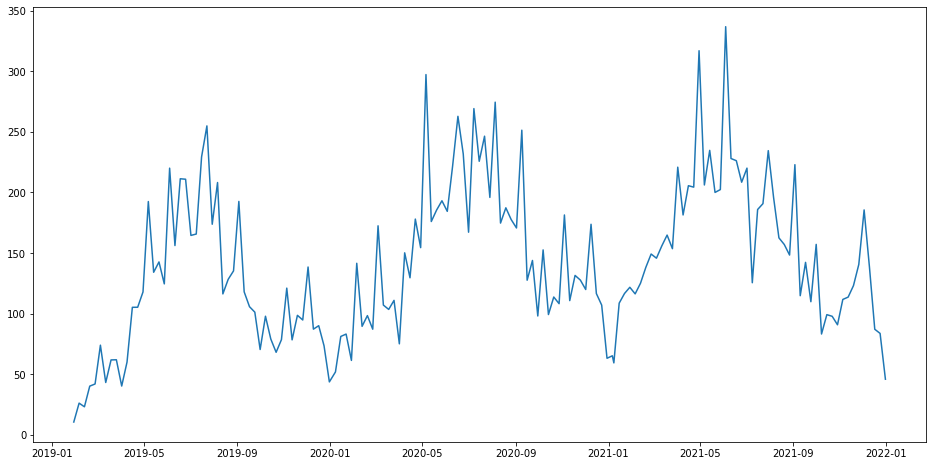

In [422]:
plt.plot(pd.DataFrame({'relative_dates' : relative_dates, 'values' : prd}).groupby('relative_dates').sum().dropna())
plt.plot(pd.DataFrame({'relative_dates' : relative_dates, 'values' : y_train.quantity_sold}).groupby('relative_dates').sum().dropna())
plt.plot()

[]

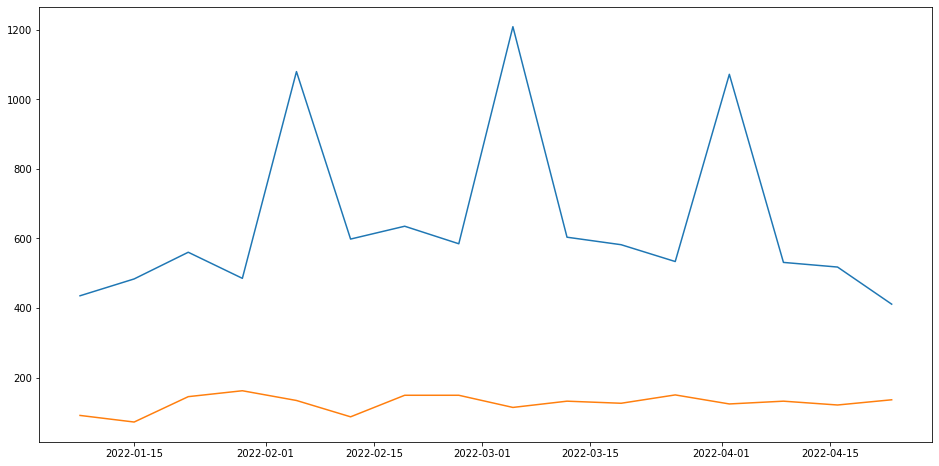

In [391]:
plt.plot(pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : prd_t}).groupby('relative_dates').sum().dropna())
plt.plot(pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : y_test.quantity_sold}).groupby('relative_dates').sum().dropna())
plt.plot()

In [ ]:
def feature_importance_xgb(df : pd.DataFrame, TEST_SIZE : int = 30) -> pd.DataFrame:
    """
    Let's check the importance of features based on TEST_SIZE random cluster predictions
    """
    tested = [[]]
    xgb_feature_importance = []
    
    for check in range (TEST_SIZE):
        
        test_cluster = []
        while test_cluster in tested:
            test_cluster = [random.randint(1, 101), random.randint(1, 3)] 
        
        tested.append(test_cluster)

        X_train, y_train, X_test, y_test = prepare_cluster_split_data(df, test_cluster[1], test_cluster[0])

        xgb = XGBRegressor(learning_rate = 0.1, n_estimators=1000,
                           max_depth=5, min_child_weight=1,
                           gamma=0, subsample=0.8,
                           colsample_bytree=0.8, objective= "reg:squarederror",  
                           nthread=-1,scale_pos_weight=1, seed=27)
        
        xgb.fit(X_train, y_train)

        if check == 0:
            xgb_feature_importance = xgb.feature_importances_
        else:
            xgb_feature_importance += xgb.feature_importances_
            
        print(f'Done {check+1} out of {TEST_SIZE} models. ({(1+check)*100/TEST_SIZE}%)')
    
    return(xgb.get_booster().feature_names, xgb_feature_importance / TEST_SIZE)

In [ ]:
names, values = feature_importance_xgb(data, 5)

In [ ]:
values

In [ ]:
names

In [468]:
xgb = XGBRegressor(learning_rate = 0.05, n_estimators=250,
                           max_depth=4, min_child_weight=1,
                           gamma=0, subsample=0.8, reg_lambda=10,
                           
                           early_metric='auc',
                           eval_set=[(X_test, y_test)],
                               
                           colsample_bytree=0.8, objective= "reg:squarederror",  
                           nthread=-1,scale_pos_weight=1, seed=27,
                          importance_type='total_gain')

xgb.fit(X_train, y_train)

[20:11:45] WARNING: ../src/learner.cc:627: 
Parameters: { "early_metric", "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_metric='auc', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             eval_set=[(      year  week  month  item_unit_price_with_vat  product_purchase_price  \
51  2022.0   1.0    1.0                    13.874                6.800000   
52  2022.0   2.0    1.0                    13.874                6.800000   
53  2022.0   3.0    1.0                    1...
[11894 rows x 1 columns])],
             gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type='total_gain', interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor=

In [485]:
xgb = XGBRegressor(learning_rate = 0.05, n_estimators=250,
                           max_depth=4, min_child_weight=1,
                           gamma=0, subsample=0.8, reg_lambda=10,
                           
                   
                               
                           colsample_bytree=0.8, objective= "reg:squarederror",  
                           nthread=-1,scale_pos_weight=1, seed=27,
                          importance_type='total_gain')

In [451]:
xgb = XGBRegressor(learning_rate = 0.1, n_estimators=100,
                           max_depth=5, min_child_weight=1,
                           gamma=0, subsample=0.8,
                           colsample_bytree=0.8, objective= "reg:squarederror",  
                           nthread=-1,scale_pos_weight=1, seed=27,
                          importance_type='total_gain')

In [486]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type='total_gain', interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
             random_state=27, reg_alpha=0, ...)

In [487]:
predicted = xgb.predict(X_train)
predicted_test = xgb.predict(X_test)

In [488]:
print(median_absolute_error(y_train.quantity_sold, predicted))
print(median_absolute_error(y_test.quantity_sold, predicted_test))

print('\n')

print(mean_absolute_error(y_train.quantity_sold, predicted))
print(mean_absolute_error(y_test.quantity_sold, predicted_test))

0.06470286101102829
0.03953728452324867


0.1995549120842966
0.21663198517407606


In [471]:
train_predicted = pd.DataFrame({'relative_dates' : relative_dates, 'values' : predicted}).groupby('relative_dates').sum().dropna()

In [472]:
test_predicted = pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : predicted_test}).groupby('relative_dates').sum().dropna()

In [473]:
train_real = pd.DataFrame({'relative_dates' : relative_dates, 'values' : y_train.quantity_sold}).groupby('relative_dates').sum().dropna()
test_real = pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : y_test.quantity_sold}).groupby('relative_dates').sum().dropna()

<ipython-input-489-728664bbcc98>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(train_predicted.append(test_predicted))
<ipython-input-489-728664bbcc98>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(train_real.append(test_real))


[]

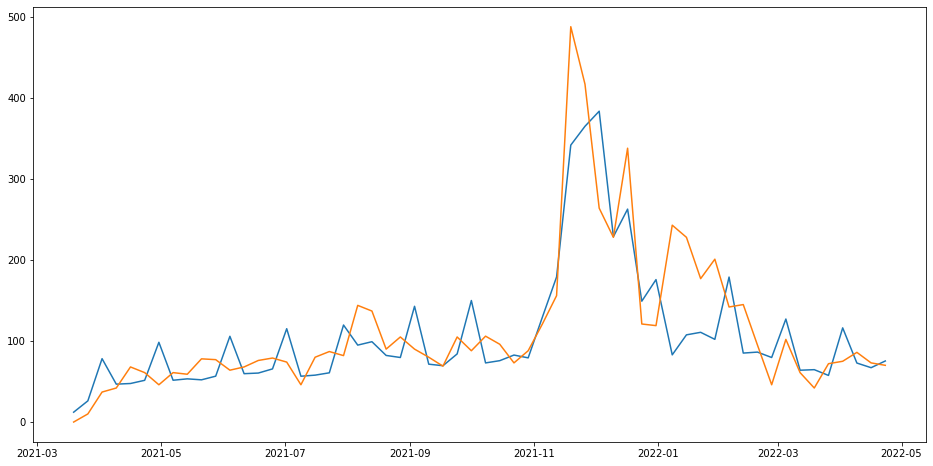

In [489]:
plt.plot(train_predicted.append(test_predicted))
plt.plot(train_real.append(test_real))
plt.plot()

[]

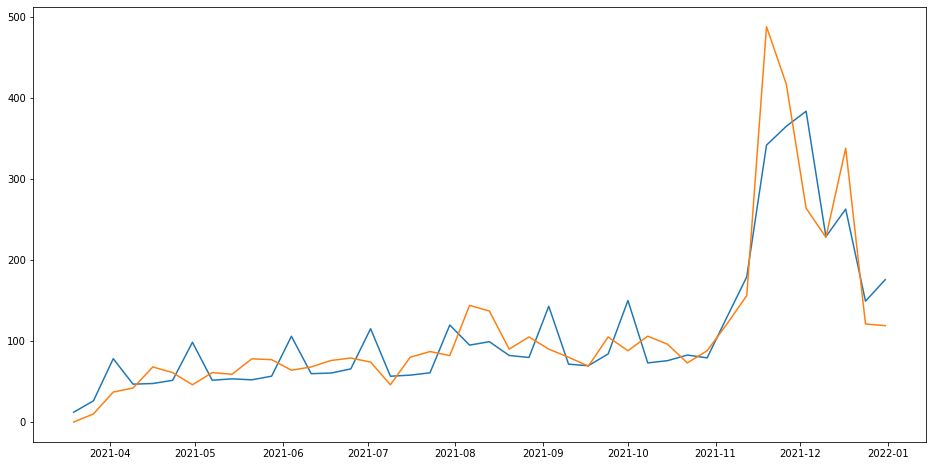

In [490]:
plt.plot(pd.DataFrame({'relative_dates' : relative_dates, 'values' : predicted}).groupby('relative_dates').sum().dropna())
plt.plot(pd.DataFrame({'relative_dates' : relative_dates, 'values' : y_train.quantity_sold}).groupby('relative_dates').sum().dropna())
plt.plot()

[]

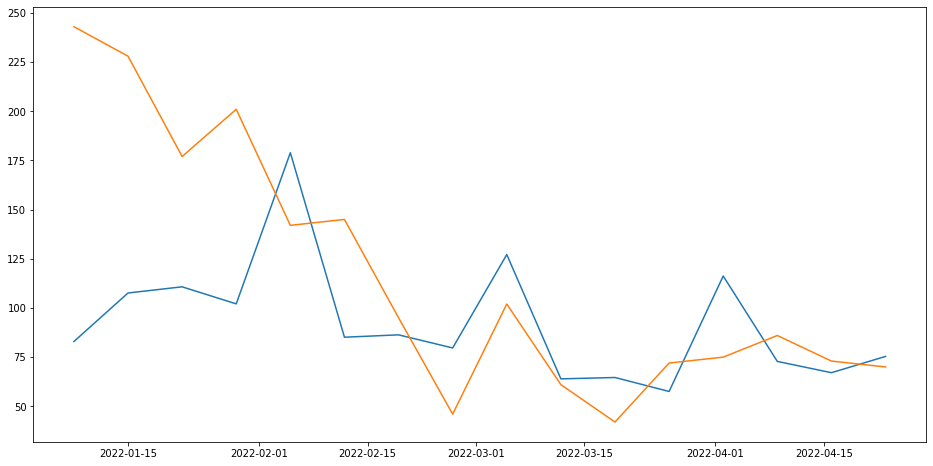

In [491]:
plt.plot(pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : predicted_test}).groupby('relative_dates').sum().dropna())
plt.plot(pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : y_test.quantity_sold}).groupby('relative_dates').sum().dropna())
plt.plot()

In [ ]:
from datetime import date
from dateutil.relativedelta import relativedelta

relative_dates = [date(int(train.iloc[i].year), 1, 1) + relativedelta(weeks =+ train.iloc[i].week) for i in range(len(train.index))]
relative_dates_test = [date(int(test.iloc[i].year), 1, 1) + relativedelta(weeks =+ test.iloc[i].week) for i in range(len(test.index))]

In [273]:
xgb.get_booster().get_score(importance_type='weight')

{'year': 262.0,
 'item_unit_price_with_vat': 2379.0,
 'product_purchase_price': 861.0,
 'item_total_discount_with_vat': 1785.0,
 'product_id': 920.0,
 'category_id': 365.0,
 'brand_id': 350.0,
 'segment_id': 29.0,
 'reviews_count': 360.0,
 'reviews_average_score_price': 146.0,
 'reviews_average_score_quality': 68.0,
 'reviews_average_score_properties': 54.0,
 'reviews_average_score_overall': 16.0,
 'reviews_average_score': 213.0,
 'product_status': 49.0,
 'ancestor_count': 28.0,
 'days_in_shop': 858.0,
 'sold_1_days_ago': 613.0,
 'sold_2_days_ago': 540.0,
 'sold_3_days_ago': 457.0,
 'sold_4_days_ago': 388.0,
 'sold_5_days_ago': 540.0,
 'week_sin': 518.0,
 'week_cos': 530.0,
 'month_sin': 129.0,
 'month_cos': 206.0}

In [430]:
relative_dates = [date(int(train.iloc[i].year), 1, 1) + relativedelta(weeks =+ train.iloc[i].week) for i in range(len(train.index))]
relative_dates_test = [date(int(test.iloc[i].year), 1, 1) + relativedelta(weeks =+ test.iloc[i].week) for i in range(len(test.index))]

In [272]:
np.sort(xgb.feature_importances_)

array([0.01486097, 0.02102279, 0.0221088 , 0.02529922, 0.02537922,
       0.02650736, 0.02793965, 0.02858336, 0.03305283, 0.03316846,
       0.03431744, 0.03508835, 0.03526324, 0.03550551, 0.03672523,
       0.03719136, 0.03839761, 0.03934254, 0.04276235, 0.04598945,
       0.04823317, 0.05034517, 0.05746257, 0.05948501, 0.0676704 ,
       0.07829797], dtype=float32)

0.042878175154328346
1.7767320275306702


0.12795169040726392
3.1788617522127685


In [ ]:
(xgb.feature_importances_ + xgb.feature_importances_ + xgb.feature_importances_)  / 3

In [51]:
for i in range (len(xgb.feature_importances_)):
    print(xgb.get_booster().feature_names[i], xgb.feature_importances_[i])

year 0.024613868
week 0.02658853
month 0.020203227
item_unit_price_with_vat 0.06508416
product_purchase_price 0.05965301
item_total_discount_with_vat 0.07847696
product_id 0.045594748
item_type 0.0
category_id 0.041828282
brand_id 0.054572303
segment_id 0.03620002
reviews_count 0.046918396
reviews_average_score_price 0.061150797
reviews_average_score_quality 0.029831044
reviews_average_score_properties 0.021293074
reviews_average_score_overall 0.015572622
reviews_average_score 0.033793602
product_status 0.0270877
is_ended 0.053929824
is_new 0.0
is_boosted 0.0
is_fifo 0.0
category_status 0.0
ancestor_count 0.049971484
descendant_count 0.0
days_in_shop 0.032036524
sold_1_days_ago 0.040643185
sold_2_days_ago 0.0317722
sold_3_days_ago 0.043436717
sold_4_days_ago 0.025073081
sold_5_days_ago 0.034674678


In [ ]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()